In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [2]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [3]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [4]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [6]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lpm_ols = LinearProductRegressorBCD()

In [7]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, Loss: 1.0119e+00
Iteration 2/10, Loss: 1.0118e+00
Iteration 3/10, Loss: 1.0118e+00
Converged at iteration 3 with Loss: 1.0118e+00


In [8]:
df['model_predict'] = lpm_ols.predict(train_df)

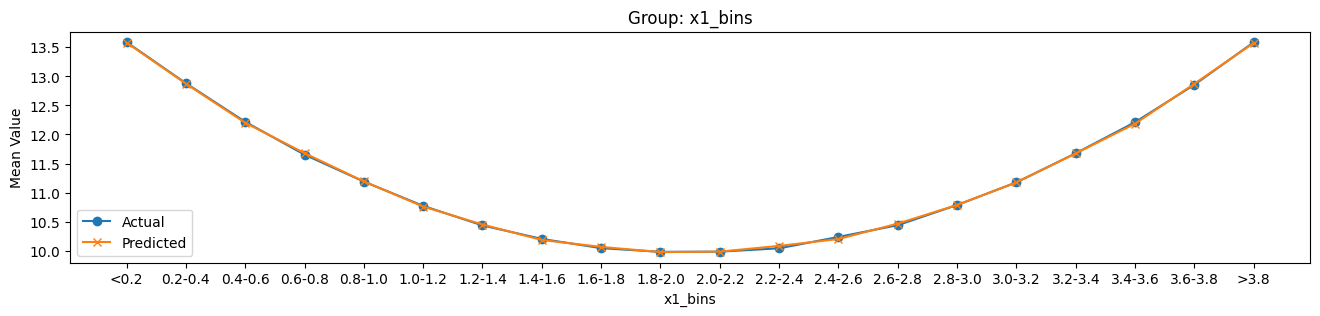

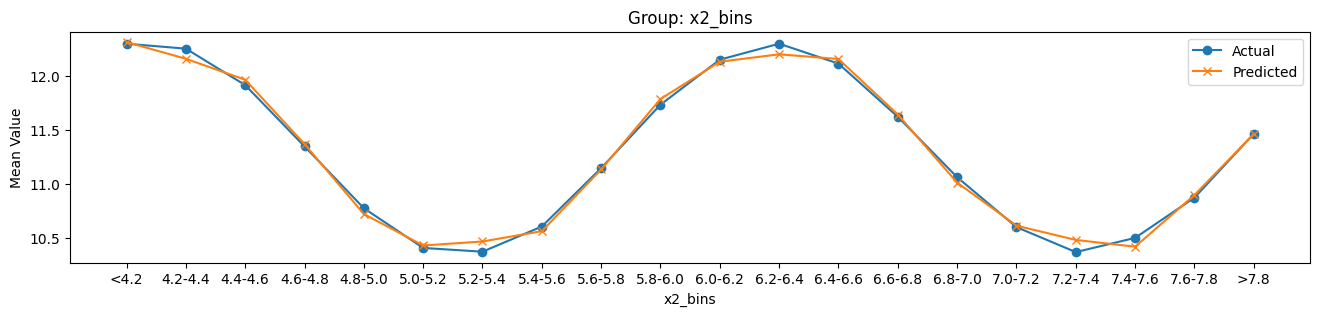

In [9]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classifier: SciPy Optimizer

In [10]:
np.random.seed(15)
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

0.06902

In [11]:
from quantbullet.linear_product_model import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-8, gtol=1e-8, eps=1e-3)

In [12]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Iter 1: 24906.30856086498
Iter 2: 24230.129167459258
Iter 3: 23186.617543117583
Iter 4: 22910.41562052604
Iter 5: 22816.884765077997
Iter 6: 22788.898302750742
Iter 7: 22713.723101373103
Iter 8: 22638.975065973606
Iter 9: 22578.225533776367
Iter 10: 22455.094544853655
Iter 11: 22301.715662220362
Iter 12: 22124.587060405614
Iter 13: 22110.982916404762
Iter 14: 22095.599411264397
Iter 15: 22082.137109700332
Iter 16: 22076.170966826623
Iter 17: 22074.659496172357
Iter 18: 22074.427808936234
Iter 19: 22074.16159245221
Iter 20: 22073.608388743916
Iter 21: 22072.04697367612
Iter 22: 22068.406876025965
Iter 23: 22060.297237360555
Iter 24: 22046.7074751052
Iter 25: 22037.345228534392
Iter 26: 22018.76995045491
Iter 27: 21999.72075185444
Iter 28: 21998.8997065668
Iter 29: 21996.93768743205
Iter 30: 21993.037306148246
Iter 31: 21983.943013851826
Iter 32: 21964.98991245167
Iter 33: 21934.564440367052
Iter 34: 21902.80277095756
Iter 35: 21889.501666761917
Iter 36: 21889.090426873798
Iter 37: 21889

In [13]:
lpc_scipy.coef_

{'x1': array([-3.43213463, -0.96385867, -0.25433359, -0.05663947, -0.03397466,
         0.02745382,  0.07224237,  0.26299379,  0.94870782]),
 'x2': array([ 0.86070843, -0.34423618, -0.78431075,  0.00701848,  0.84075637,
         0.27003373, -1.0751415 , -0.14784829,  0.87275159])}

In [14]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

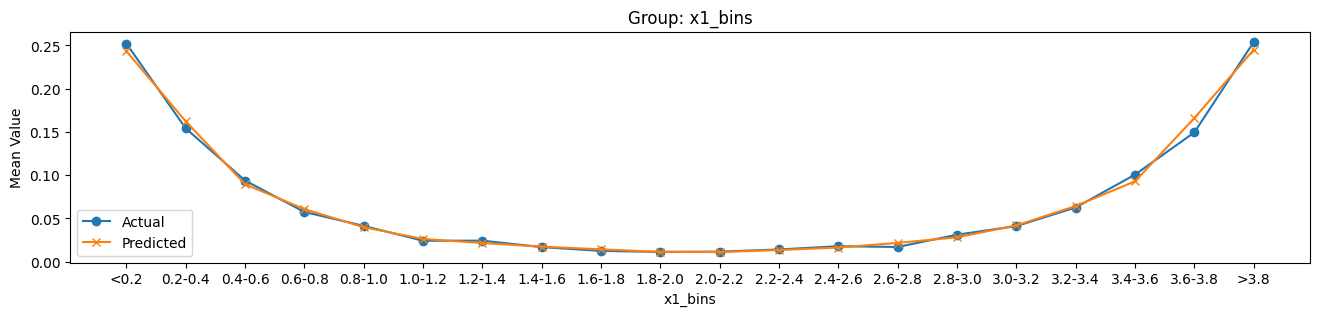

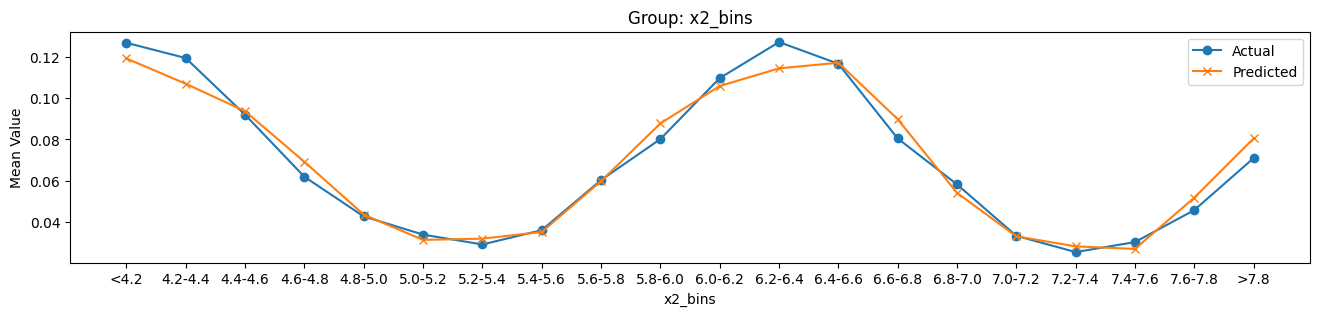

In [15]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classifier: Block Coordinate Descent

In [16]:
from quantbullet.linear_product_model import LinearProductClassifierBCD

In [17]:
lpc_bcd = LinearProductClassifierBCD()

In [18]:
lpc_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=20, early_stopping_rounds=10 )

Iteration 1/20, Loss: 0.2044
Iteration 2/20, Loss: 0.2045
Iteration 3/20, Loss: 0.2044
Iteration 4/20, Loss: 0.2044
Iteration 5/20, Loss: 0.2044
Iteration 6/20, Loss: 0.2044
Iteration 7/20, Loss: 0.2045
Iteration 8/20, Loss: 0.2044
Iteration 9/20, Loss: 0.2044
Iteration 10/20, Loss: 0.2045
Iteration 11/20, Loss: 0.2046
Early stopping at iteration 11 with Loss: 0.2046


In [19]:
df['clf_bcd_pred_prob'] = lpc_bcd.predict(train_df)

In [20]:
lpc_bcd.global_scalar_

0.06895332614847297

In [21]:
df['binary_y'].mean()

0.06902

In [22]:
df['clf_bcd_pred_prob'].mean()

0.0689533261484731

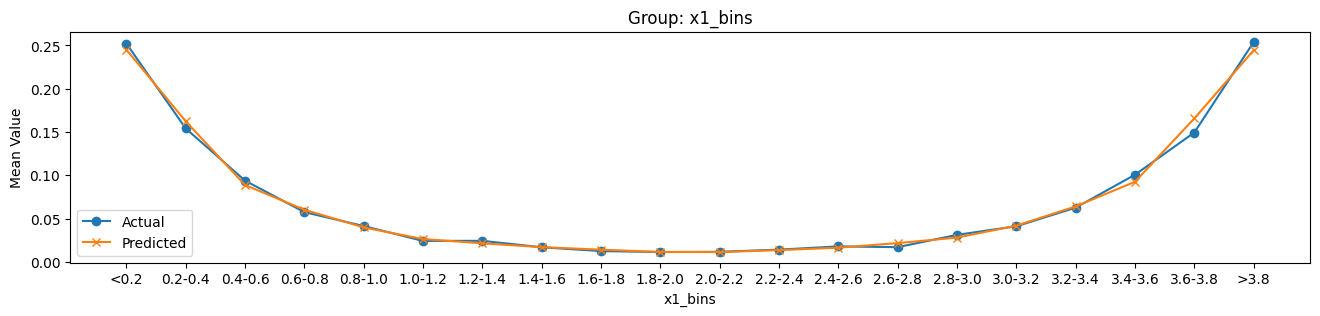

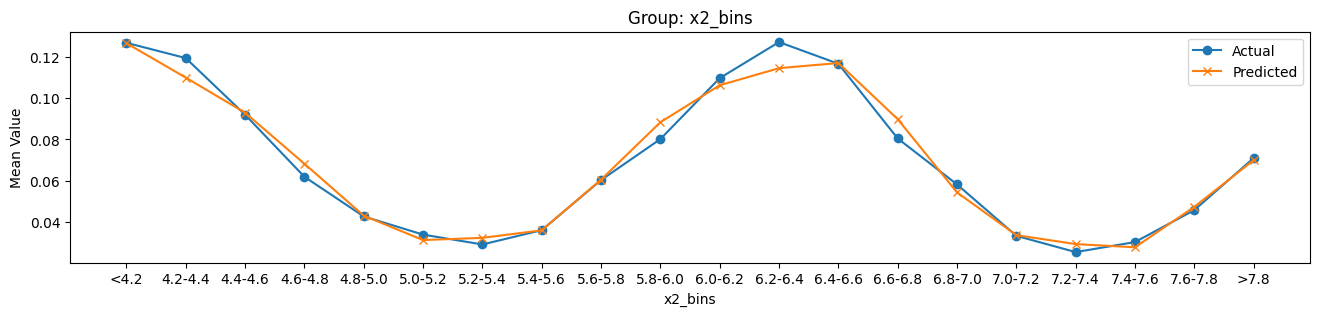

In [23]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_bcd_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_bcd_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Minimizing MSE for Classification

In [24]:
from quantbullet.linear_product_model import LinearProductRegressorBCD, LinearProductRegressorScipy

lpr_bcd = LinearProductRegressorBCD()

In [25]:
lpr_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, Loss: 5.6341e-02
Iteration 2/10, Loss: 5.6337e-02
Iteration 3/10, Loss: 5.6337e-02
Converged at iteration 3 with Loss: 5.6337e-02


In [26]:
df['model_predict_BCD'] = lpr_bcd.predict(train_df)

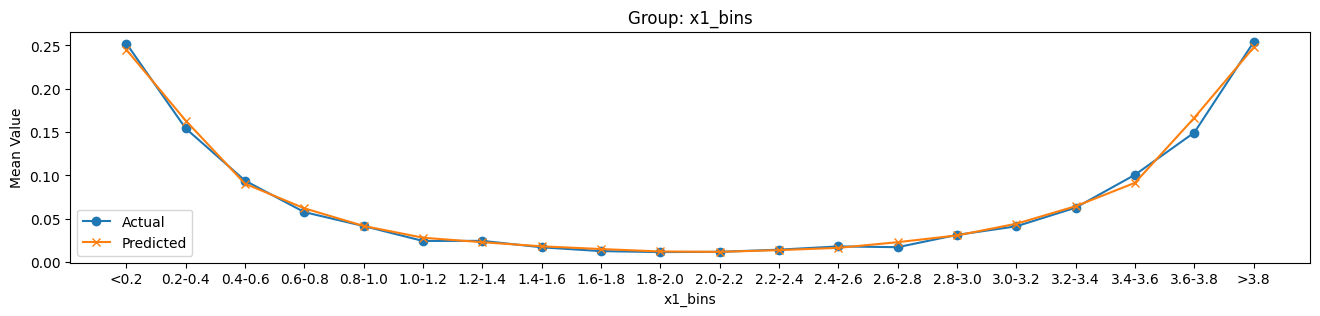

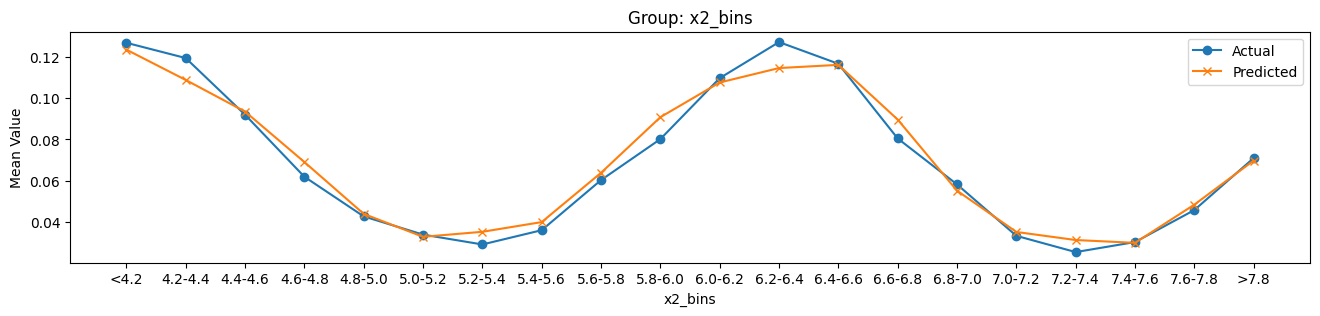

In [27]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [28]:
lpr_scipy = LinearProductRegressorScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpr_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4867e+10                                    1.44e+10    
       1              2         8.5295e+09      2.63e+10       4.24e+00       9.73e+09    
       2              4         5.3320e+08      8.00e+09       2.12e+00       1.23e+09    
       3              6         1.4020e+08      3.93e+08       1.06e+00       8.63e+08    
       4              7         2.3768e+07      1.16e+08       1.06e+00       4.67e+08    
       5              8         1.1849e+06      2.26e+07       2.12e+00       6.93e+07    
       6              9         2.2102e+04      1.16e+06       4.24e+00       7.51e+06    
       7             11         3.6412e+03      1.85e+04       2.12e+00       8.65e+04    
       8             14         3.2503e+03      3.91e+02       2.65e-01       1.26e+04    
       9             16         3.0669e+03      1.83e+02       6.63e-02       5.68e+02    

In [29]:
df['model_predict_scipy'] = lpr_scipy.predict(train_df)

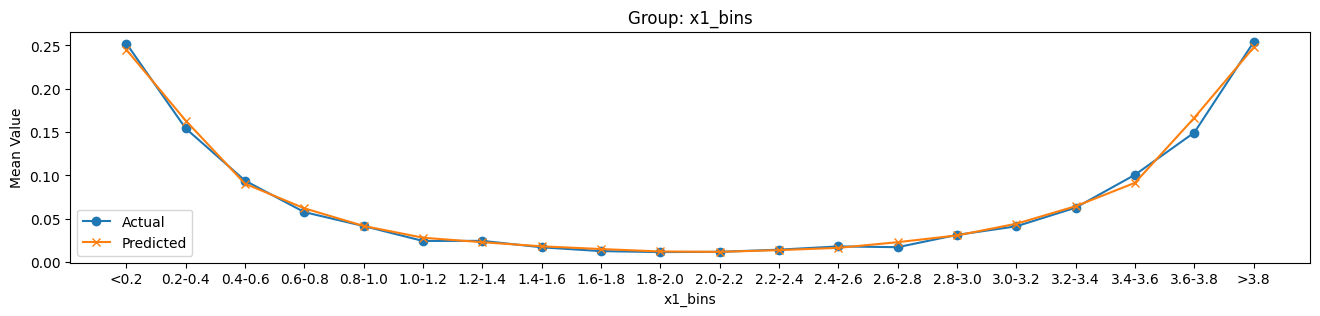

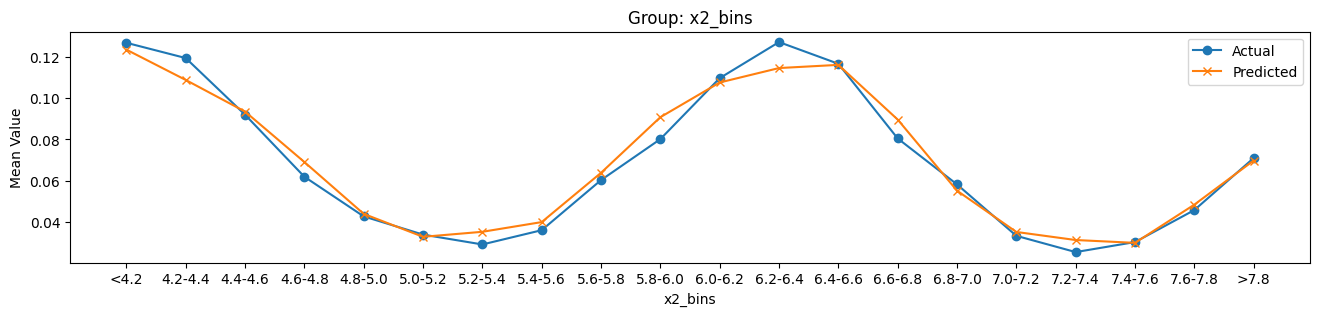

In [30]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_scipy': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_scipy'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [31]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict_scipy'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0563
MSE (Scipy Optimization): 0.0563


## Compare the classifier and regressor Coefficients

In [32]:
lpr_bcd.bias_one_coef_

{'x1': array([ 1.        ,  0.27809263,  0.07103922,  0.01822099,  0.0094846 ,
        -0.00640566, -0.02551123, -0.06826865, -0.28065021]),
 'x2': array([ 1.        , -0.16455354, -0.30347213,  0.02463448,  0.31839944,
         0.08797254, -0.40914735, -0.04718991,  0.2563163 ])}

In [33]:
lpc_bcd.bias_one_coef_

{'x1': array([ 1.        ,  0.28586981,  0.07252957,  0.01747585,  0.00892527,
        -0.00761908, -0.02097884, -0.07638023, -0.27708758]),
 'x2': array([ 1.        , -0.18193826, -0.2951631 ,  0.00816411,  0.31974638,
         0.09999393, -0.4085889 , -0.05069536,  0.2637907 ])}